In [2]:
import hydra
from omegaconf import OmegaConf
from glob import  glob
from rosa import  predict


BASE_DIR = "/Users/nsofroniew/Documents/data/rosa/outputs/2023-03-09/21-32-17" # /home/ec2-user/
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = BASE_DIR + "/checkpoints/epoch=*.ckpt"
    chkpt = glob(chkpts)[0]

    adata, rdm, rlm = predict(config, chkpt)

# display(adata)
print(chkpt)

Global seed set to 0
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/var/folders/6n/b_zkz2ns3_l02s3g4lnlklxr0000gq/T/ipykernel_95487/2464734954.py:10: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume

RosaLightningModule(
  (model): RosaFormerModel(
    (main): Sequential(
      (dual_embed): ParallelEmbed(
        (models): ModuleList(
          (0): Sequential(
            (input_embed_0): MaskedEmbed(
              (model): Sequential(
                (projection): Embedding(513, 64)
                (layer_norm): Identity()
                (dropout): Dropout(p=0, inplace=False)
              )
            )
          )
          (1): Sequential(
            (layer_norm_1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
            (input_embed_1): InputEmbed(
              (model): Sequential(
                (projection): Linear(in_features=3072, out_features=64, bias=True)
                (layer_norm): Identity()
                (dropout): Dropout(p=0, inplace=False)
              )
            )
          )
        )
      )
      (join_embeds): AddEmbeds()
      (transformer): Identity()
      (dropout): Dropout(p=0, inplace=False)
      (expression_head): ProjectionE

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
Missing logger folder: /Users/nsofroniew/Documents/GitHub/rosa/notebooks/lightning_logs
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/Users/nsofroniew/Documents/data/rosa/outputs/2023-03-09/21-32-17/checkpoints/epoch=25-step=156.ckpt


In [3]:
predicted = adata.layers['predicted']
measured = adata.layers['measured']
confidence = adata.layers['confidence']

In [4]:
measured.shape

(132, 19431)

In [5]:
from sklearn.metrics import confusion_matrix

In [6]:
cm = confusion_matrix(measured.flatten(), predicted.flatten())

In [8]:
import matplotlib.pyplot as plt

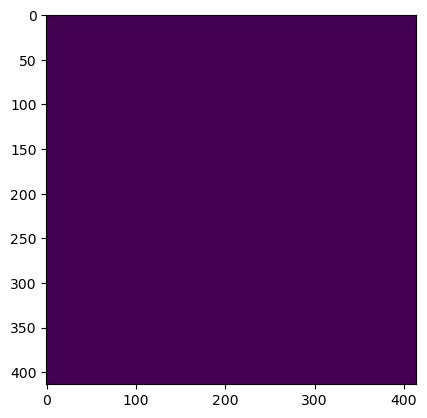

In [9]:
plt.imshow(cm);

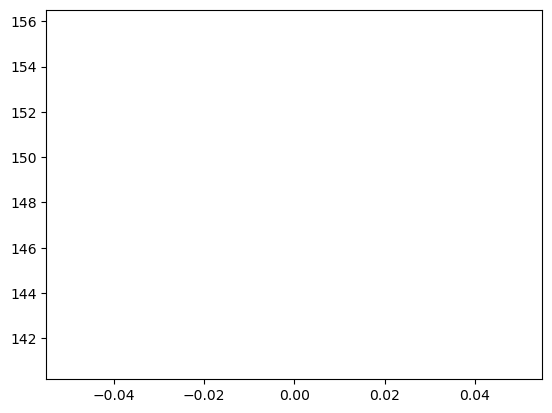

In [11]:
plt.imshow(cm);

In [14]:
from rosa.utils import score_predictions, plot_expression_and_correlation, plot_marker_gene_heatmap


adata_test, results = score_predictions(adata)


        mean spearmanr across genes 0.376
        mean spearmanr across cells nan
        mean square error 66935.966
        ks-statistic on total expression 0.676
        mean percent total expression captured per cell 111.915
        


/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/nsofroniew/Documents/GitHub/rosa/rosa/utils/score.py:41: RuntimeWarning: Mean of empty slice
  results["spearmanr_across_cells_mean"] = np.nanmean(


/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6613: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6614: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


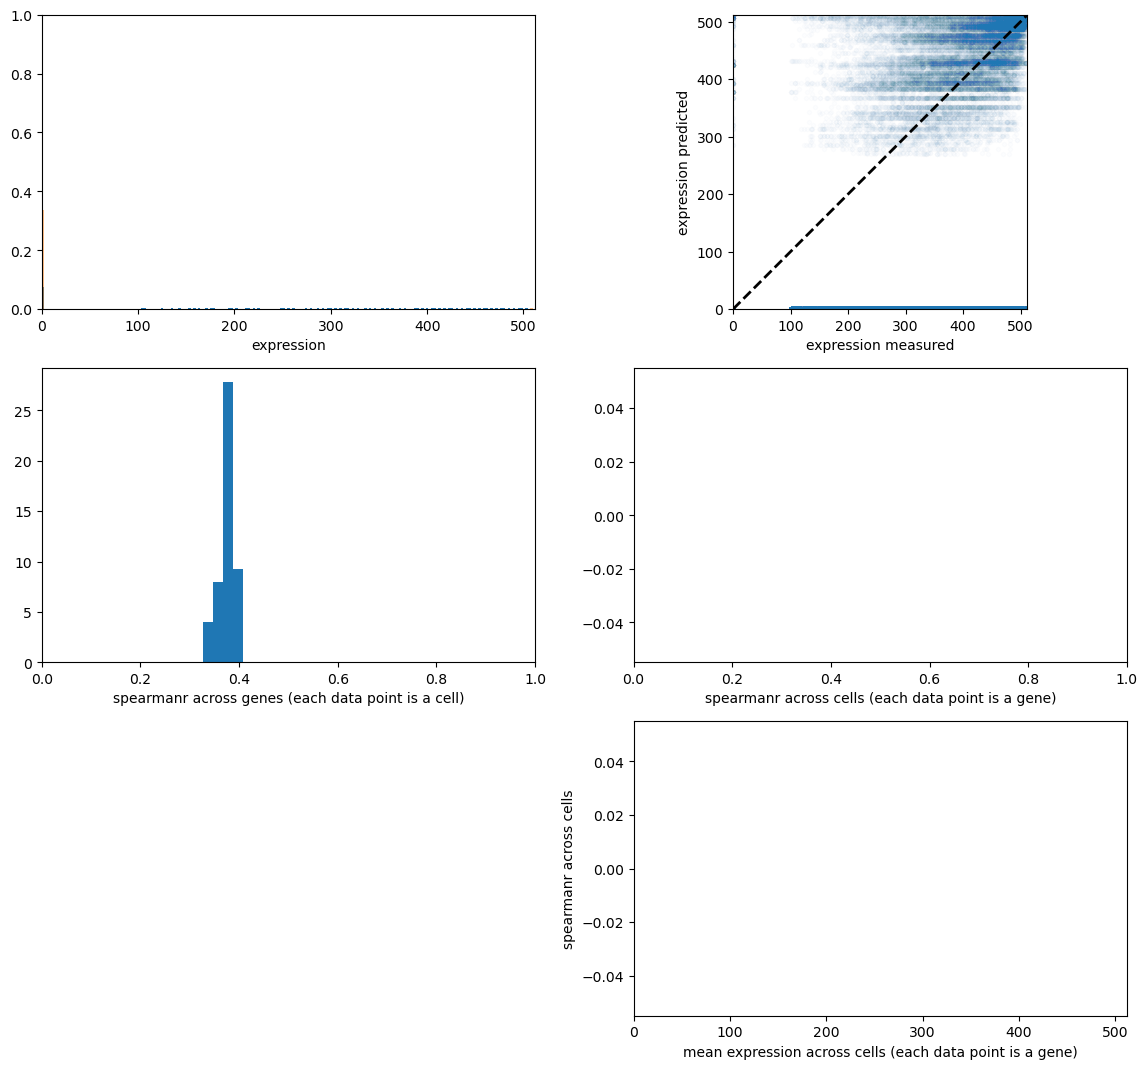

In [15]:
if config.data_module.data.expression_transform.n_bins is not None:
    max_expression_val = config.data_module.data.expression_transform.n_bins
else:
    max_expression_val = 6
    
plot_expression_and_correlation(adata_test, results, max_expression_val=max_expression_val)

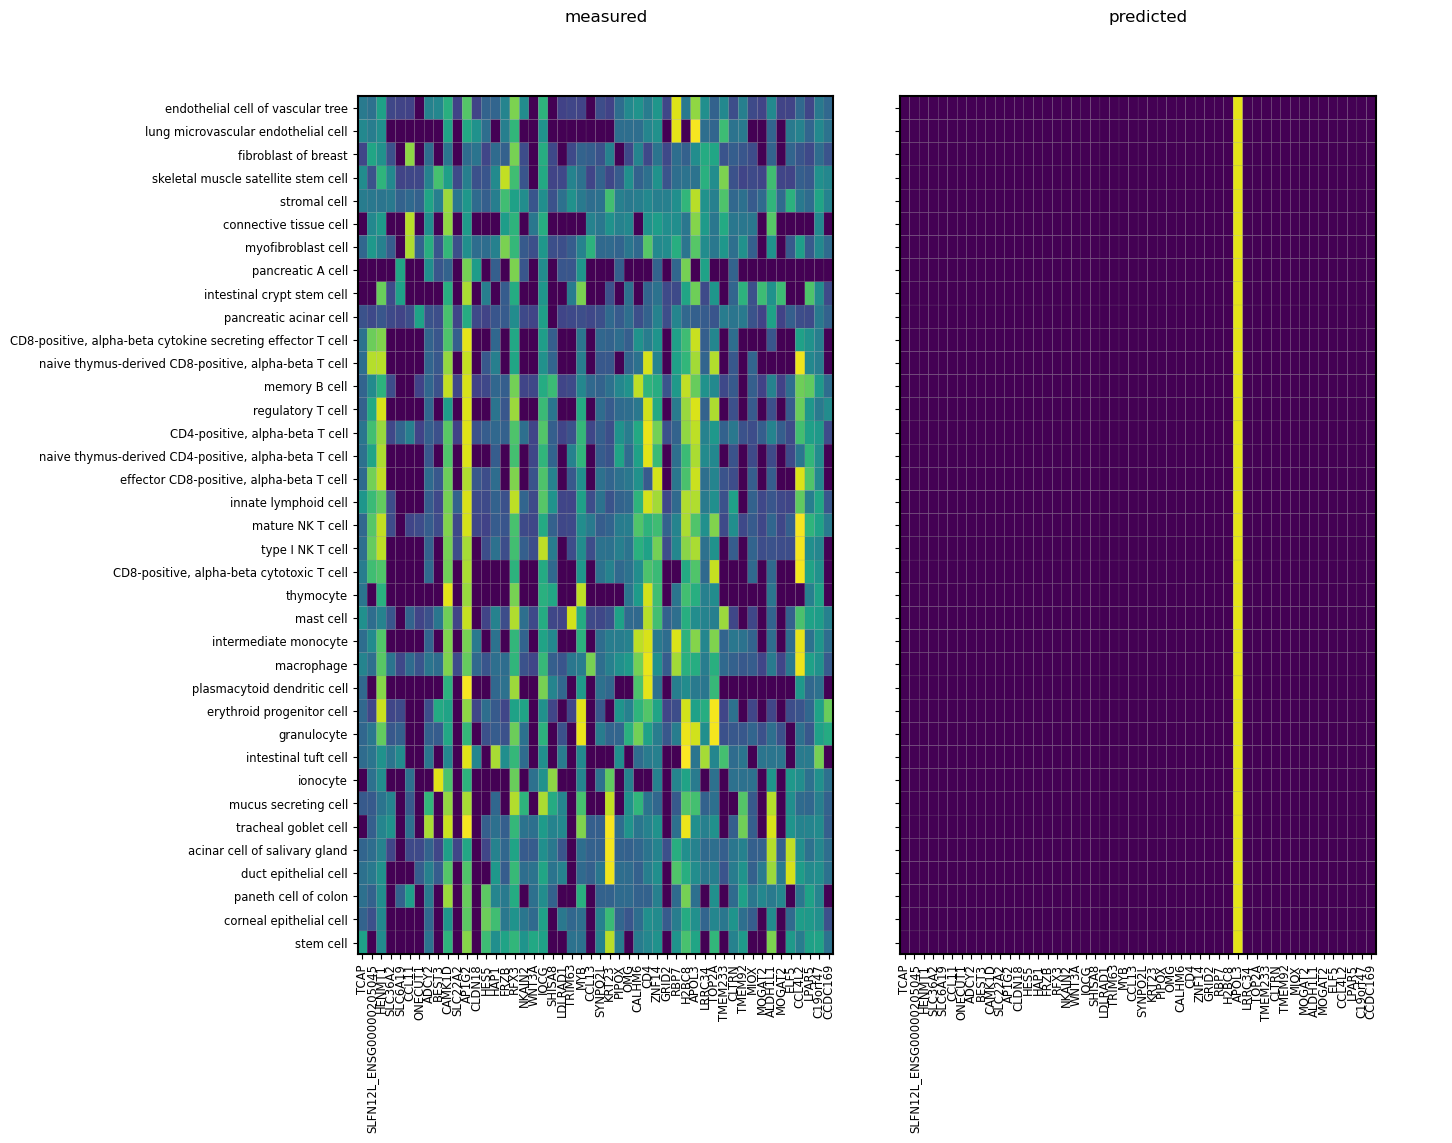

In [16]:
import numpy as np


marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes, max_expression_val=max_expression_val)

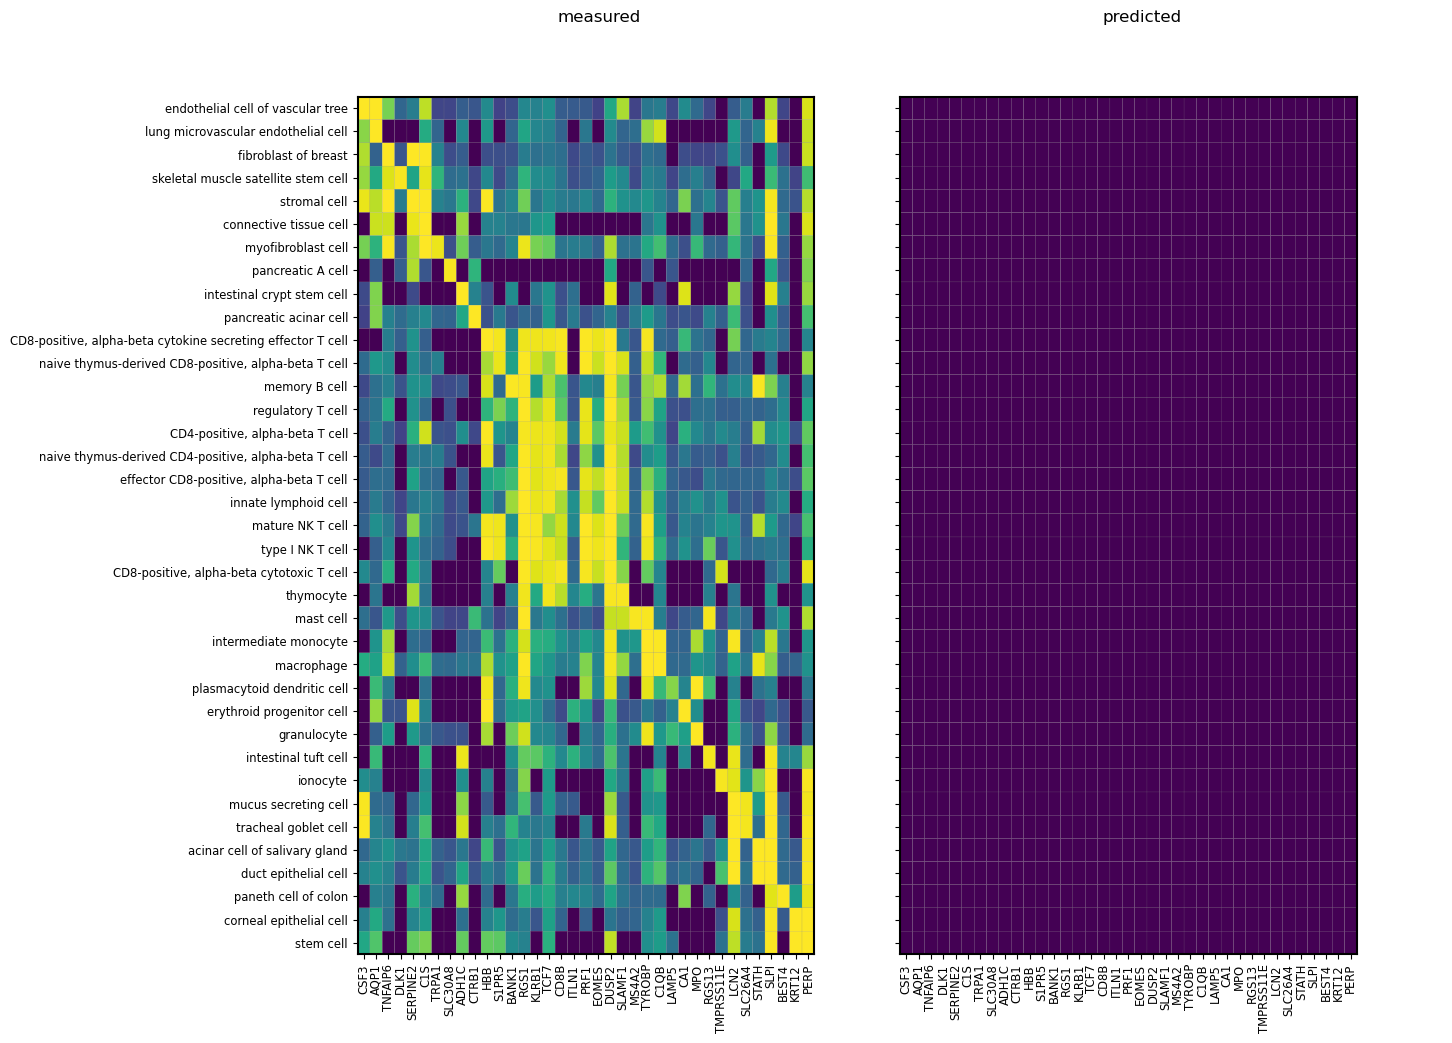

In [17]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict, max_expression_val=max_expression_val)

In [18]:
import seaborn as sns
from scipy.cluster.hierarchy import linkage
import sys


sys.setrecursionlimit(100000)

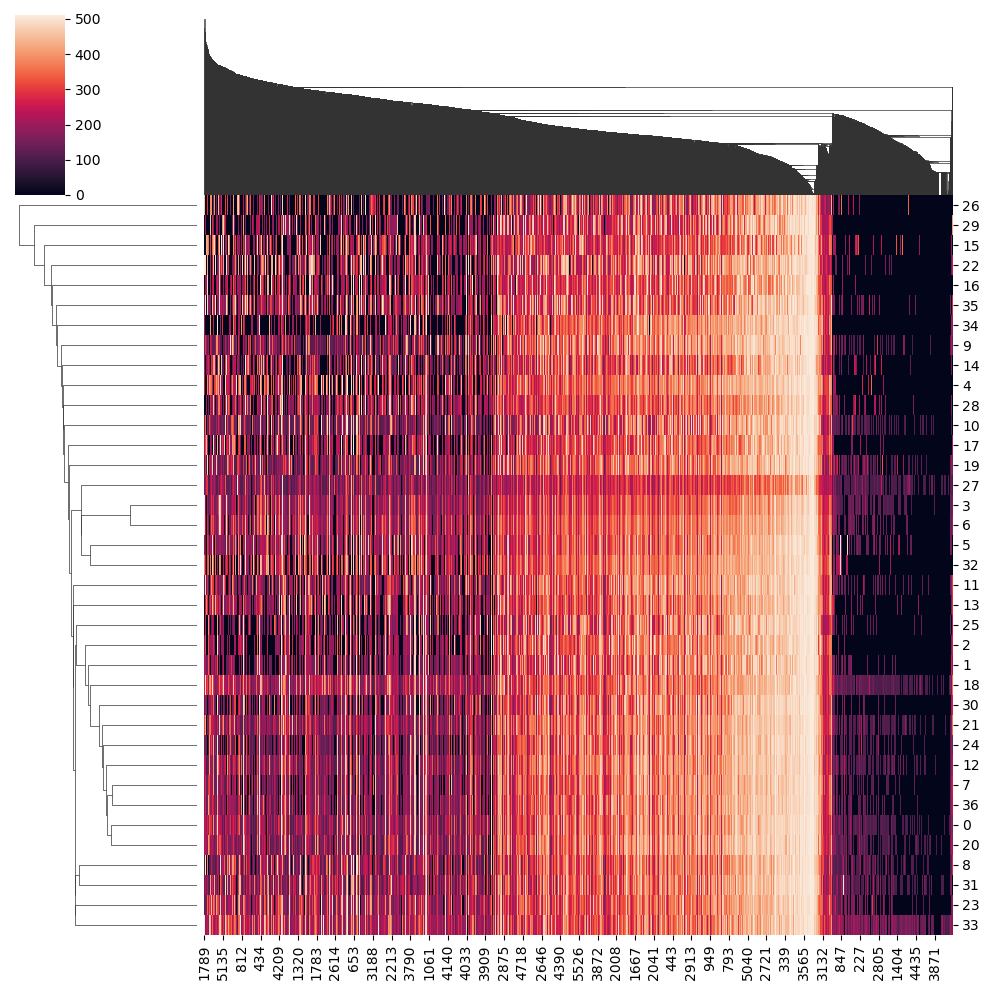

In [19]:
D = adata_test.layers['measured']

row_linkage = linkage(D) # D being the measurement
col_linkage = linkage(D.T) # D being the measurement
sns.clustermap(D, row_linkage=row_linkage, col_linkage=col_linkage)

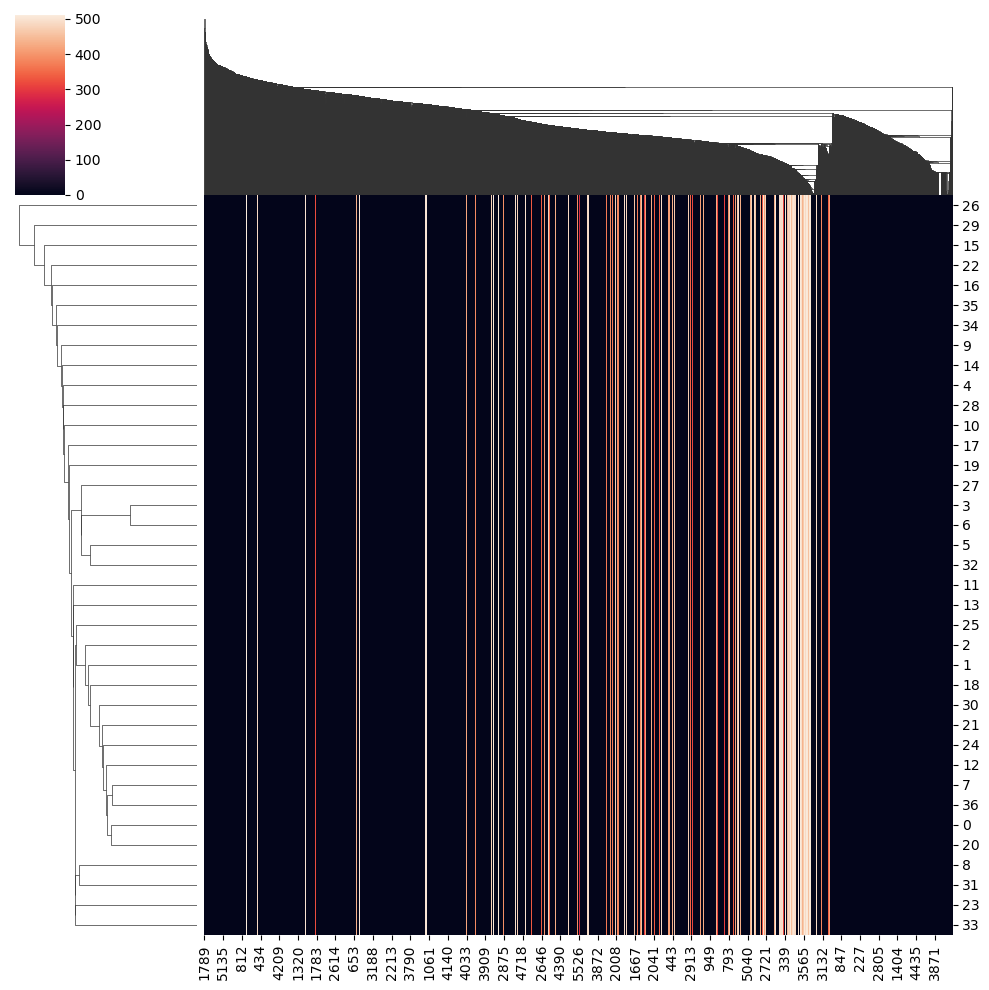

In [21]:
D = adata_test.layers['predicted']
sns.clustermap(D, row_linkage=row_linkage, col_linkage=col_linkage)

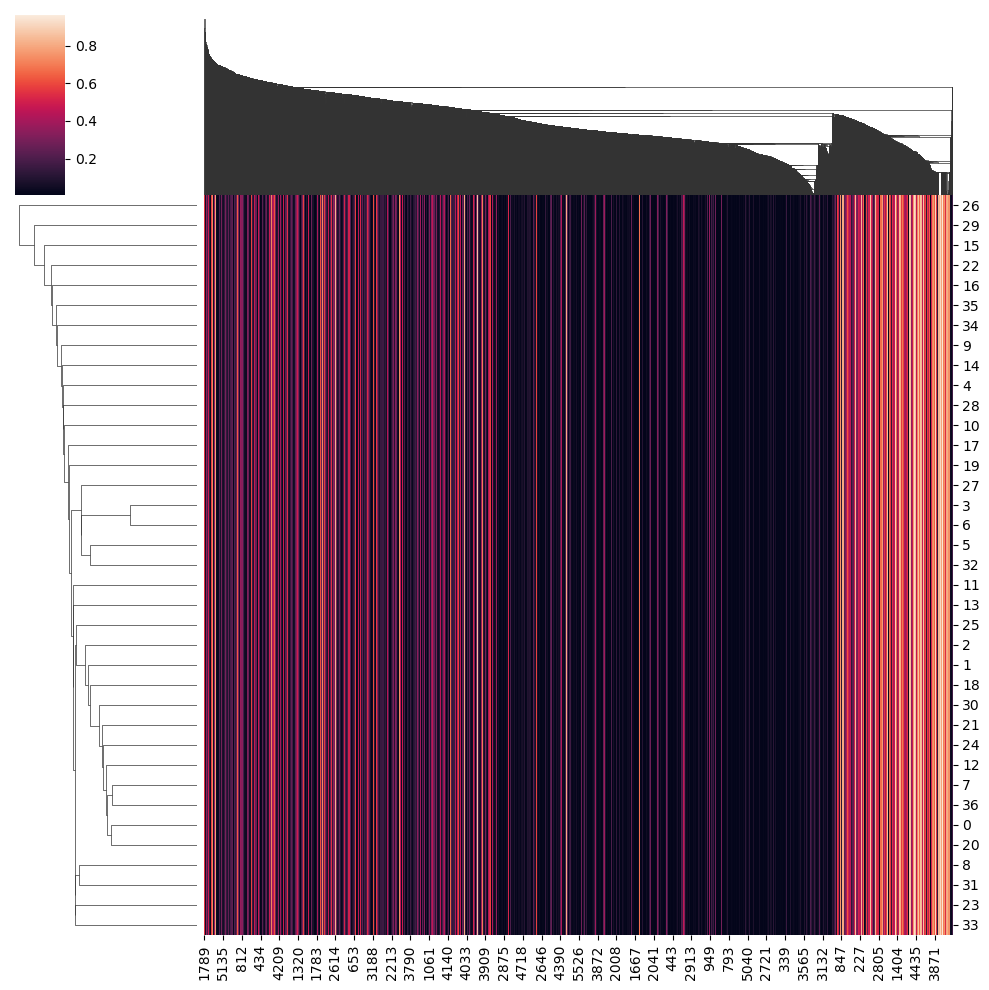

In [22]:
D = adata_test.layers['confidence']
sns.clustermap(D, row_linkage=row_linkage, col_linkage=col_linkage)